# *Drone Delivery: a Vehicle Routing Problem*

Authors: Adrian Menor, Federico Magri, Youssef Farah

// add description 

## Import Packages

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import timeit
from geopy.distance import geodesic
rnd = np.random
rnd.seed(0)

## VRP Model

### Classes 

In [2]:
#DATASET 
#Here we create the dataset
#Initialize
class Drones():
    def __init__(self, name, maxspeed, maxpayload, number_of_drones, power):
        self.name = name
        self.maxspeed = maxspeed
        self.maxpayload = maxpayload
        self.number_of_drones = number_of_drones
        self.power = power

class Clients():
    number_of_clients = 0
    depo_location = (-3.4333, 29.9000)
    def __init__(self,id, number, name, lat, long, demand):
        self.id = id
        self.number = number
        self.name = name
        self.lat = lat
        self.long = long
        self.demand = demand
        Clients.number_of_clients += 1

### Sample Dataset

In [3]:
Clients.number_of_clients = 0
drones = Drones("AAI RQ-7 Shadow", 36.1111, 10, 4, 28.5)#(name, maxspeed, maxpayload, number_of_drones, power consumtion)
infile = open('villages_burundi', 'rb')
list = pickle.load(infile)

client_list = []
for i in range(1,6):
    client = Clients(list[i+20][0],i,list[i+20][1],list[i+20][2],list[i+20][3],list[i+20][4])
    client_list.append(client)

T = 5500 # [s] total delivery duration


## Model Setup

In [4]:
# Basic problem variables
n = Clients.number_of_clients # nodes
clients = [i for i in range(1,n+1)]   # N_0
nodes = [0]+clients                   # N
N_N_0 = [(i,j) for i in nodes for j in clients if i!=j]
lat= [Clients.depo_location[0]]+[xc.lat for xc in client_list] # customer x locations
long = [Clients.depo_location[1]]+[yc.long for yc in client_list] #rnd.rand(n-1)*100 # customer y locations

In [5]:
# Drone parameters
M = drones.number_of_drones # Number of drones
K = 1000000                 # upper bound payload weight [kg]
v = drones.maxspeed         # drone speed                [m/s]
Q = drones.maxpayload       # max drone payload [kg] 
p = drones.power            #Power Consumption [kW]

In [6]:
# Decision variables
arcs = [(i,j) for i in nodes for j in nodes if i!=j]      # fully connected links (N x N)
sigma_var = [(i,j) for i in clients for j in clients ]    # going through depot
y = arcs # payload weight between paths
t = [i for i in nodes] # time at node i
a = [i for i in clients] # time between node i and depot
z = a # The energy consumed from a drone’s battery by the time it arrives at the depot directly after leaving
f = t #Enegry cosumed at location i

In [7]:
# Costs
s = {(i, j): geodesic((lat[i],long[i]),(lat[j],long[j])).m for i, j in arcs} # euclidean distances TODO change km to m
D = {i.number: i.demand for i in client_list}# demand of client rnd.randint(1,5)

In [8]:
### Creating the Model ###
m = gp.Model('CVRP')

Restricted license - for non-production use only - expires 2023-10-25


In [9]:
# Adding decision variables
x = m.addVars(arcs,vtype = GRB.BINARY,name='x') # x = arcs 
sigma = m.addVars(sigma_var,vtype = GRB.BINARY,name='sigma') 
y = m.addVars(y,vtype = GRB.CONTINUOUS,name='y') # payload weight between paths
t = m.addVars(t,vtype = GRB.CONTINUOUS,name='t') # time at node i
a = m.addVars(a,vtype = GRB.CONTINUOUS,name='a') # time between node i and the depot 
f = m.addVars(f,vtype = GRB.CONTINUOUS,name='f')
z = m.addVars(z,vtype = GRB.CONTINUOUS,name='z')
m.update()

In [10]:
# Objective function
m.setObjective(gp.quicksum(s[i,j]*x[i,j] for i,j in arcs),GRB.MINIMIZE)

In [11]:
# Constraints
m.addConstrs((gp.quicksum(x[i,j] for j in nodes if j!= i) == 1 for i in clients),name = "4a") # (4a) each node visited exactly once by a drone

m.addConstrs((gp.quicksum(x[i,j] for j in nodes if j!= i)-gp.quicksum(x[j,i] for j in nodes if j!= i)== 0 for i in nodes),name = "4b") # (4b) when node i is visited, the drone leaves

# Reusability Constraints
m.addConstrs((gp.quicksum(sigma[i,j] for j in clients) <= x[i,0] for i in clients),name = "5a") # (5a) if drone comes back to depot from location i, it can fly again
m.addConstrs((gp.quicksum(sigma[j,i] for j in clients) <= x[0,i] for i in clients),name = "5b") # (5b) if drone goes from depot to location i, it arrived previously from somewhere else
m.addConstr((gp.quicksum(x[0,i] for i in clients) - gp.quicksum(sigma[i,j] for i,j in sigma_var if i!=j) <= M),name = "5c") # (5c) more than M drones cannot fly

# Demand Constraints
m.addConstrs((gp.quicksum(y[j,i] for j in nodes if j!=i) - gp.quicksum(y[i,j] for j in nodes if j!=i) == D[i] for i in clients),name = "6a") # (6a)
m.addConstrs((y[i,j] <= K*x[i,j] for i,j in arcs if i!=j),name = "6b") # (6b)

# Time Constraints
m.addConstrs((t[i] - t[j] + s[i,j]/v <= K* (1-x[i,j]) for i,j in N_N_0 if i!=j),name = "7a") # (7a)
m.addConstrs((t[i] - a[i] + s[i,0]/v <= K * (1 - x[i,0]) for i in clients),name = "7b") # (7b)
m.addConstrs((a[i] - t[j] + s[0,j]/v <= K * (1 - sigma[i,j]) for i,j in sigma_var if i!=j),name = "7c") # (7c)
m.addConstrs((t[i] <= T  for i in clients),name = "7d_7e") # (7d)  and (7e) CHECK THIS CONSTRAINT

# Capacity Constraints
m.addConstrs((y[i,j] <= Q * x[i,j] for i,j in arcs if i!=j), name = "8a") #(8a)

# Energy Constraints
m.addConstrs((f[i] - f[j] + p*s[i,j]/v <= K*(1-x[i,j]) for i,j in N_N_0 if i!=j), name = "9a")#(9a)
m.addConstrs((f[i] - z[i] + p*s[i,0]/v <= K * (1 - x[i,0]) for i in clients),name = "9b")#(9b) 
m.addConstrs((z[i]<= K*x[i,0] for i in clients),name = "9c") #9c

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>}

In [12]:
m.update()
#Writing LP file
#m.Params.timeLimit = 200 #[s]
m.Params.MIPGap = 0
m.optimize()
m.write('model_lab.lp')

Set parameter MIPGap to value 0
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 177 rows, 107 columns and 595 nonzeros
Model fingerprint: 0x8f61e120
Variable types: 52 continuous, 55 integer (55 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e+04, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 64 rows and 28 columns
Presolve time: 0.02s
Presolved: 113 rows, 79 columns, 547 nonzeros
Variable types: 41 continuous, 38 integer (38 binary)
Found heuristic solution: objective 408595.99737

Root relaxation: objective 2.268948e+05, 73 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 226894.846    0    8 408595.997 226894.846  44.5%     -    0s
H 

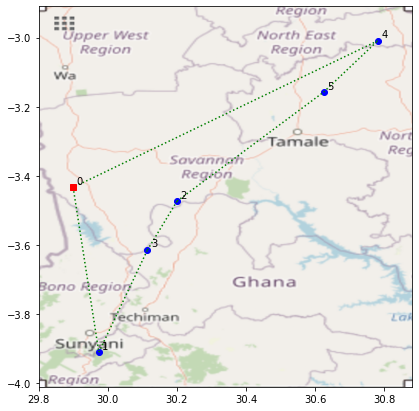

In [13]:
#Plotting
BBox = ((min(long)-0.1,   max(long)+0.1,  min(lat)-0.1, max(lat)+0.1))
ruh_m = plt.imread('map.png')

active_arcs = [a for a in arcs if x[a].x > 0.99]
fig, ax = plt.subplots(figsize = (8,7))

for i, j in active_arcs:
    ax.plot([long[i], long[j]], [lat[i], lat[j]], c='g', linestyle= ':', zorder=1)
    ax.annotate(nodes[i], (long[i]+0.01, lat[i]+0.01))

ax.plot(long[0], lat[0], c='r', marker='s')
ax.scatter(long[1:], lat[1:], c='b')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])


ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

In [14]:
for v in m.getVars():
        print(str(v.VarName)+'='+str(v.x))
print(m.objVal)

x[0,1]=1.0
x[0,2]=-0.0
x[0,3]=-0.0
x[0,4]=-0.0
x[0,5]=-0.0
x[1,0]=-0.0
x[1,2]=-0.0
x[1,3]=1.0
x[1,4]=-0.0
x[1,5]=-0.0
x[2,0]=-0.0
x[2,1]=-0.0
x[2,3]=-0.0
x[2,4]=-0.0
x[2,5]=1.0
x[3,0]=-0.0
x[3,1]=-0.0
x[3,2]=1.0
x[3,4]=-0.0
x[3,5]=-0.0
x[4,0]=1.0
x[4,1]=0.0
x[4,2]=-0.0
x[4,3]=0.0
x[4,5]=-0.0
x[5,0]=-0.0
x[5,1]=-0.0
x[5,2]=-0.0
x[5,3]=-0.0
x[5,4]=1.0
sigma[1,1]=0.0
sigma[1,2]=-0.0
sigma[1,3]=-0.0
sigma[1,4]=0.0
sigma[1,5]=-0.0
sigma[2,1]=-0.0
sigma[2,2]=0.0
sigma[2,3]=-0.0
sigma[2,4]=-0.0
sigma[2,5]=-0.0
sigma[3,1]=-0.0
sigma[3,2]=-0.0
sigma[3,3]=0.0
sigma[3,4]=-0.0
sigma[3,5]=-0.0
sigma[4,1]=0.0
sigma[4,2]=0.0
sigma[4,3]=0.0
sigma[4,4]=0.0
sigma[4,5]=0.0
sigma[5,1]=0.0
sigma[5,2]=0.0
sigma[5,3]=0.0
sigma[5,4]=0.0
sigma[5,5]=0.0
y[0,1]=10.0
y[0,2]=0.0
y[0,3]=0.0
y[0,4]=0.0
y[0,5]=0.0
y[1,0]=0.0
y[1,2]=0.0
y[1,3]=8.000000000000025
y[1,4]=0.0
y[1,5]=0.0
y[2,0]=0.0
y[2,1]=0.0
y[2,3]=0.0
y[2,4]=0.0
y[2,5]=3.999999999999911
y[3,0]=0.0
y[3,1]=0.0
y[3,2]=6.000000000000057
y[3,4]=0.0
y[3,5]=0.0